# A simple drift detection example

For a simple example, we'll use the [MMD detector](../cd/methods/mmddrift.ipynb) to check for drift on the two-dimensional binary classification problem shown previously. The MMD detector is a kernel-based method for multivariate two sample testing. Since the number of dimensions is already low, dimension reduction step is not necessary here here. For a more advanced example using the [MMD detector](../cd/methods/mmddrift.ipynb) with dimension reduction, check out the [Maximum Mean Discrepancy drift detector on CIFAR-10](cd_mmd_cifar10.ipynb) example. 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

The true model/process is defined as:

$$
y =
\begin{cases}
    1 & \text{if } x_2 > sx_1 \\
    0 & \text{otherwise}
\end{cases}
$$

where the slope $s$ is set as $s=-1$. 

In [4]:
import numpy as np
from scipy.stats import multivariate_normal

def true_model(X,slope=-1):
    z = slope*X[:,0]
    idx = np.argwhere(X[:,1]>z)
    y = np.zeros(X.shape[0])
    y[idx] = 1
    return y

true_slope = -1

The reference distribution is defined as a mixture of two Normal distributions:

$$
P_{ref}(\mathbf{X}) = \phi_1 \mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right) + \phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$

with the standard deviation set at $\sigma=0.8$, and the weights
set to $\phi_1=\phi_2=0.5$. Reference data $\mathbf{X}^{ref}$ and training data $\mathbf{X}^{train}$ (see Note 1) can be generated by sampling from this distribution. The corresponding labels $y^{ref}$ and $y^{train}$ are obtained by evalulating `true_model()`.

In [7]:
# Reference distribution
sigma = 0.8
phi1 = 0.5
phi2 = 0.5
ref_norm_0 = multivariate_normal([-1,-1], np.eye(2)*sigma**2)
ref_norm_1 = multivariate_normal([ 1, 1], np.eye(2)*sigma**2)

# Reference data (to initialise the detectors)
N_ref = 240
X_0 = ref_norm_0.rvs(size=int(N_ref*phi1),random_state=1)
X_1 = ref_norm_1.rvs(size=int(N_ref*phi2),random_state=1)
X_ref = np.vstack([X_0, X_1])
y_ref = true_model(X_ref,true_slope)

# Training data (to train the classifer)
N_train = 240
X_0 = ref_norm_0.rvs(size=int(N_train*phi1),random_state=0)
X_1 = ref_norm_1.rvs(size=int(N_train*phi2),random_state=0)
X_train = np.vstack([X_0, X_1])
y_train = true_model(X_train,true_slope)

To save time later on, a plotting function is defined:

In [8]:
plt.rcParams.update({'font.size': 16})

def plot(X,y, slope, clf=None):
    # Init plot
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.axis('equal')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xlim([-3.5,3.5])
    ax.set_ylim([-6,3.3])
    
    # Plot data
    cmap = LinearSegmentedColormap.from_list('my_cmap', [(0.78,0.44,0.22), (0.22, 0.44, 0.78)], N=2)
    scat = ax.scatter(X[:,0], X[:,1],c=y,ec='k',s=70,cmap=cmap,alpha=0.7)
    
    # Plot true decision boundary
    xconcept = np.array(ax.get_xlim())
    ax.plot(xconcept,xconcept*slope,'k--',lw=2,alpha=0.8)
    
    if clf is not None:
        # Plot classifier decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        XX, YY = np.meshgrid(xx, yy)
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3, levels=1)
        ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=[2,0], levels=1,alpha=0.8)

    plt.show()
    
labels = ['No','Yes']

For a model, we choose the well-known decision tree classifier. As well as training the model, this is a good time to initialise the MMD detector with the held-out reference data $\mathbf{X}^{ref}$ by calling:

```python
detector = MMDDrift(X_ref, backend='pytorch', p_val=.05)
```

The significance threshold is set at $\alpha=0.05$, meaning the detector will flag results as drift detected when the computed $p$-value is less than this i.e. $\hat{p}< \alpha$. 

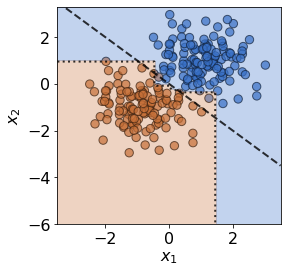

Mean training accuracy 99.17%
No GPU detected, fall back on CPU.


In [10]:
# Fit decision tree classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Plot
plot(X_ref,y_ref,true_slope,clf=clf)

# Classifier accuracy
print('Mean training accuracy %.2f%%' %(100*clf.score(X_ref,y_ref)))

# Fit a drift detector to the training data
from alibi_detect.cd import MMDDrift
detector = MMDDrift(X_ref, backend='pytorch', p_val=.05)

## No drift

Before introducing drift, we first examine the case where no drift is present. We resample from the same mixture of Gaussian distributions to generate test data $\mathbf{X}$. The individual data observations are different, but the underlying distributions are unchanged, hence no true drift is present. 

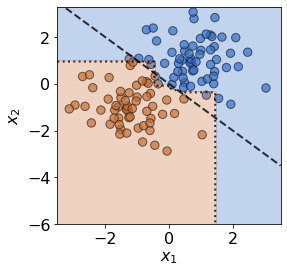

Mean test accuracy 95.00%


In [18]:
N_test = 120
X_0 = ref_norm_0.rvs(size=int(N_test*phi1),random_state=2)
X_1 = ref_norm_1.rvs(size=int(N_test*phi2),random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,true_slope)
plot(X_test,y_test,true_slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

Unsurprisingly, the model's mean test accuracy is relatively high. To run the detector on test data the `.predict()` is used:

In [12]:
detector.predict(X_test)

{'data': {'is_drift': 0,
  'distance': 0.0023595122654528344,
  'p_val': 0.23999999463558197,
  'threshold': 0.05,
  'distance_threshold': 0.007951605},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'pytorch'}}

For the test statistic $S(\mathbf{X})$, the MMD detector uses the
[kernel trick](https://en.wikipedia.org/wiki/Kernel_method) to
compute unbiased estimates of $\text{MMD}^2$. The
$\text{MMD}$ is a distance-based measure between the two
distributions $P$ and $P_{ref}$, based on the mean
embeddings $\mu$ and $\mu_{ref}$ in a reproducing kernel
Hilbert space $F$:

$$
\text{MMD}^2\left(F, P, P_{ref}\right) = \lVert \mu - \mu_{ref} \rVert^2_{F}
$$

A $p$-value is then obtained via a [permutation
test](<https://en.wikipedia.org/wiki/Resampling_(statistics)>) on the
estimates of $\text{MMD}^2$. As expected, since we are sampling from
the reference distribution $P_{ref}(\mathbf{X})$, the detector’s
prediction is `'is_drift':0` here, indicating that drift is not
detected. More specifically, the detector’s $p$-value (`p_val`)
is above the threshold of $\alpha=0.05$ (`threshold`),
indicating that no statistically significant drift has been detected.
The `.predict()` method also returns $\hat{S}(\mathbf{X})$
(`distance_threshold`), which is the threshold in terms of the test
statistic $S(\mathbf{X})$ i.e. when
$S(\mathbf{X})\ge \hat{S}(\mathbf{X})$ statistically significant
drift has been detected.

## Covariate and prior drift 

To impose covariate drift, we apply a shift to the mean of one of the normal distributions:

$$
P(\mathbf{X}) = \phi_1 \mathcal{N}\left(\left[-1\color{red}{+3},-1\color{red}{-3}\right]^T, \sigma^2\mathbf{I} \right) +
\phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$


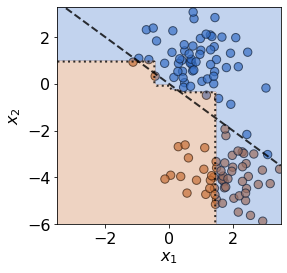

Mean test accuracy 66.67%
Is drift? Yes!


In [16]:
shift_norm_0 = multivariate_normal([2, -4], np.eye(2)*sigma**2)
X_0 = shift_norm_0.rvs(size=int(N_test*phi1),random_state=2)
X_1 = ref_norm_1.rvs(size=int(N_test*phi2),random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,true_slope)
plot(X_test,y_test,true_slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

# Check for drift in covariates
pred = detector.predict(X_test)
print('Is drift? %s!' %labels[pred['data']['is_drift']])

The test data has drifted into a previously unseen region of feature space, and the model is now misclassifying a number of test observations. If true test labels are available, this is easily detectable by monitoring the test accuracy. However, labels aren't always avaiable at test time, in which case a drift detector monitoring the covariates comes in handy. In this case, the MMD detector successfully detects the covariate drift.

In a similar manner, a proxy for prior drift can be monitored by initialising a detector on labels from the reference set, and then feeding it a model's predicted labels:

```python
label_detector = MMDDrift(y_ref.reshape(-1,1), backend='tensorflow', p_val=.05)
y_pred = clf.predict(X_test)
label_detector.predict(y_pred.reshape(-1,1))
```

## Concept drift 

Concept drift detectors are coming soon!